# Experimente zur Erstellung eines Deep Learning Modells zur Klassifikation!

### Importieren der benötigten Bibliotheken

Hier werden alle notwendigen Bibliotheken und Module importiert, die für die Datenverarbeitung und das Modelltraining benötigt werden.

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf 
import tensorflow_hub as hub
import tensorflow_io as tfio
import sys
sys.path.append("../EchoWatch")

2023-09-28 10:07:41.460292: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 10:07:41.596670: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-28 10:07:41.596695: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-28 10:07:42.183945: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

### Herunterladen des Datensatzes

Die Pumpendaten werden von einer externen Quelle heruntergeladen und lokal gespeichert. Das Dataset enthält Audiodateien von Maschinengeräuschen.

In [2]:
_ = tf.keras.utils.get_file('pump.zip',
                        'https://zenodo.org/record/3678171/files/dev_data_pump.zip?download=1',
                        cache_dir='../',
                        cache_subdir='data',
                        extract=True)

### Hilfsfunktion zum Laden von WAV-Dateien

Die Funktion `load_wav_16k_mono` lädt eine WAV-Datei, konvertiert sie in einen Float-Tensor und resampled sie auf 16 kHz. Dies stellt sicher, dass alle Audiodateien im gleichen Format vorliegen.

In [3]:
# Utility functions for loading audio files and making sure the sample rate is correct.

@tf.function
def load_wav_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(
          file_contents,
          desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

### Definieren der Testdateipfade

Hier werden die Pfade für positive (normale) und negative (anomale) Testdateien definiert. Diese Dateien werden später verwendet, um das Audiosignal zu visualisieren und zu analysieren.

In [4]:
neg_test_file = os.path.join('../data/pump/test/anomaly_id_00_00000000.wav')
pos_test_file = os.path.join('../data/pump/test/normal_id_00_00000000.wav')

### Laden und Visualisieren der WAV-Dateien

Die Audiodateien werden geladen und ihre Wellenformen werden visualisiert. Dies gibt einen ersten Einblick in die Struktur der Audiosignale.

In [5]:
wave = load_wav_16k_mono(pos_test_file)
nwave = load_wav_16k_mono(neg_test_file)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


2023-09-28 10:07:53.267864: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA


2023-09-28 10:07:54.074456: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-09-28 10:07:54.074523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lxd-24q-05): /proc/driver/nvidia/version does not exist
2023-09-28 10:07:54.075883: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


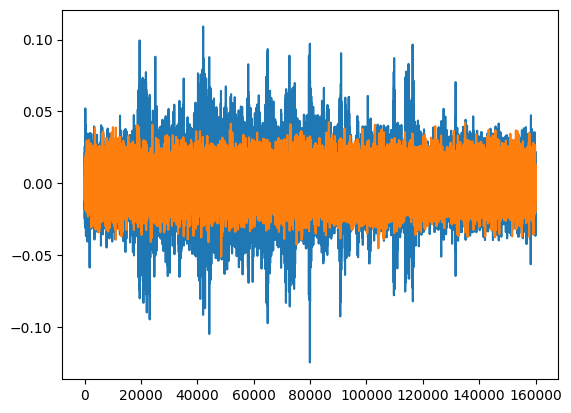

In [6]:
plt.plot(nwave) # Blau
plt.plot(wave) # Orange
plt.show()

### Definieren des Datensatzpfads

Der Pfad zum Testdatensatz wird definiert, um den Zugriff auf die Audiodateien zu erleichtern.

In [7]:
Datensatz = os.path.join('../data/pump/test')
Datensatz

'../data/pump/test'

### Erstellen von Dateipfaden und zugehörigen Labels für den Datensatz

Für jede Audiodatei im Datensatz wird der Dateipfad und das zugehörige Label (normal oder anomal) erstellt. Dies erleichtert die weitere Verarbeitung und das Training des Modells.

In [8]:
file_paths = [os.path.join(Datensatz, filename) for filename in os.listdir(Datensatz)]
labels = [1 if 'normal' in filename else 0 for filename in os.listdir(Datensatz)]

data = tf.data.Dataset.from_tensor_slices((file_paths, labels))

# Jetzt haben Sie das Dataset mit den Dateipfaden und den entsprechenden Labels

### Anzeigen eines zufälligen Eintrags aus dem Datensatz

Ein zufälliger Eintrag aus dem Datensatz wird angezeigt, um die Konsistenz und Struktur der Daten zu überprüfen.

In [9]:
data.shuffle(10000).as_numpy_iterator().next()

(b'../data/pump/test/normal_id_04_00000074.wav', 1)

### Anzeigen des gesamten Datensatzes

Der gesamte Datensatz wird angezeigt. Dies gibt einen Überblick über die Struktur des Datasets und die vorhandenen Daten.

In [10]:
data

<TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

### Vorverarbeitung der Audiodaten
Die Funktion preprocess führt mehrere Schritte zur Vorverarbeitung von Audiodaten durch:

In [11]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

### Anpassung und Auffüllen der Audiodaten
Das Audiosignal wird zuerst mit load_wav_16k_mono geladen und dann auf eine Länge von 160.000 Samples beschnitten. Falls das Signal kürzer ist, wird es mit Nullen aufgefüllt, um diese Länge zu erreichen.

In [12]:
wav = load_wav_16k_mono(pos_test_file)
wav = wav[:160000]
zero_padding = tf.zeros([160000] - tf.shape(wav), dtype=tf.float32)
wav = tf.concat([zero_padding, wav],0)
wav

<tf.Tensor: shape=(160000,), dtype=float32, numpy=
array([-4.9438427e-09,  4.8834387e-08, -1.7519886e-07, ...,
       -6.5181381e-03,  3.6144694e-03,  1.7607301e-03], dtype=float32)>

### Erstellung und Anpassung des Spektrogramms
Ein Spektrogramm des Audiosignals wird mit der Short-Time Fourier Transform (STFT) erstellt. Anschließend wird der Betrag des Spektrogramms genommen, um komplexe Werte in absolute Werte zu konvertieren. Zuletzt wird eine zusätzliche Dimension hinzugefügt, um das Spektrogramm für nachfolgende Verarbeitungsschritte vorzubereiten.

In [13]:
spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.expand_dims(spectrogram, axis=2)

### Zufällige Auswahl von Daten
Ein zufälliges Datenpaar, bestehend aus Dateipfad und zugehörigem Label, wird aus dem Datensatz ausgewählt. Der Datensatz wird zuerst durchmischt (shuffle), wobei eine Puffergröße von 10.000 verwendet wird, um die Mischreihenfolge zu bestimmen. Anschließend wird das erste Element des durchmischten Datensatzes ausgewählt.

In [14]:
filepath, label = data.shuffle(buffer_size=10000).as_numpy_iterator().next()

### Anwendung der Vorverarbeitung
Das zuvor ausgewählte Audiosignal (über den Dateipfad) und das zugehörige Label werden durch die preprocess Funktion verarbeitet. Das Ergebnis ist ein Spektrogramm des Audiosignals und das unveränderte Label.

In [15]:
spectrogram, label = preprocess(filepath, label)

### Visualisierung des Spektrogramms
Das berechnete Spektrogramm wird visualisiert. Die Darstellung erfolgt in einem großformatigen Plot mit den Maßen 30x20. Das Spektrogramm wird transponiert, um es korrekt darzustellen, wobei nur der erste Kanal gezeigt wird.

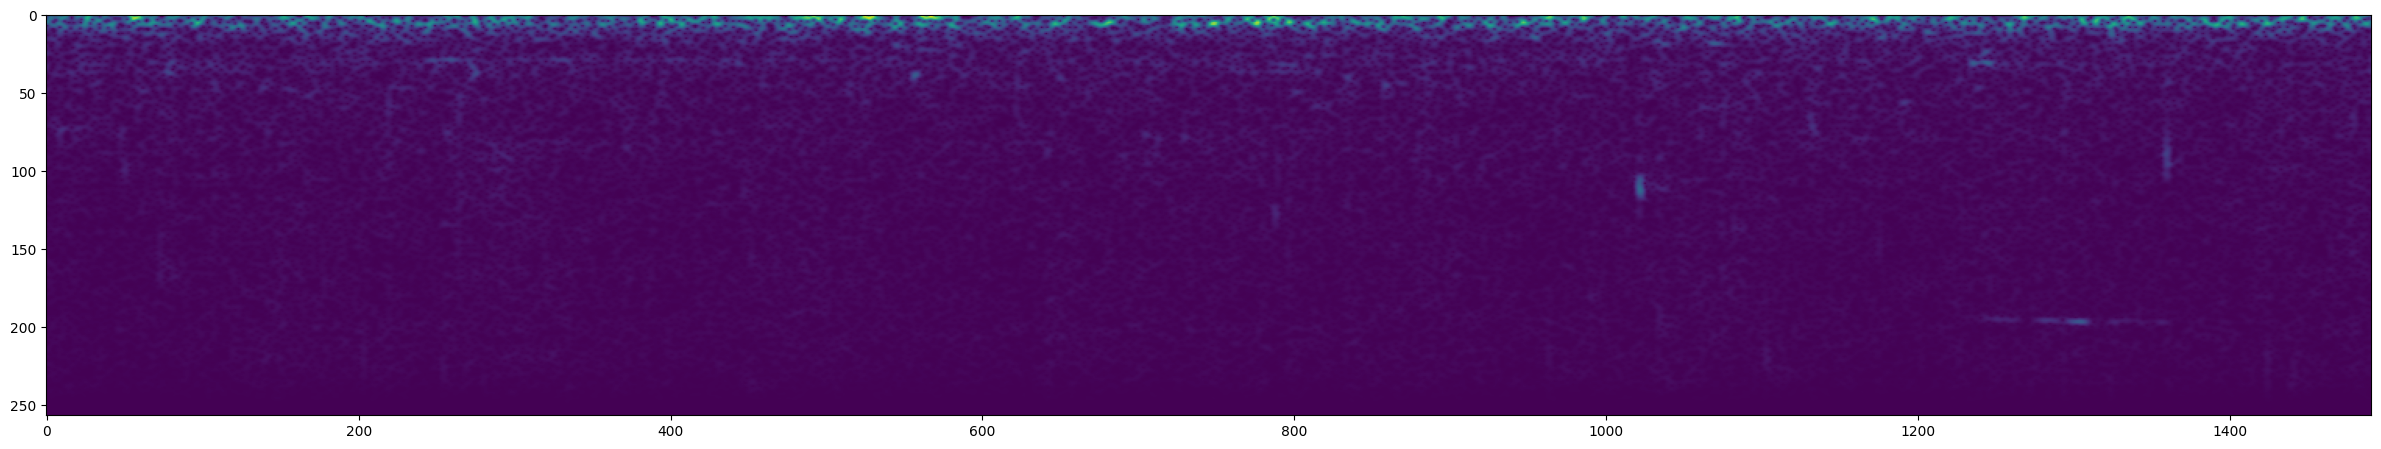

In [16]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

### Datenverarbeitung und Vorbereitung für das Training
Vorverarbeitung: Jedes Element im Datensatz wird mit der preprocess Funktion verarbeitet, um Spektrogramme zu erhalten.

Zwischenspeichern: Die Daten werden im Cache gespeichert, um das Laden während des Trainings zu beschleunigen.

Mischen: Der Datensatz wird durchmischt, wobei eine Puffergröße von 1.000 verwendet wird.

Batching: Die Daten werden in Batches von jeweils 16 Einträgen gruppiert, was für das Training von neuronalen Netzwerken üblich ist.

Vorabladen: Es werden 8 Batches im Voraus geladen, um die Datenbereitstellung während des Trainings zu optimieren.

In [17]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

### Aufteilen des Datensatzes in Trainings- und Testdaten
Der Datensatz wird in zwei Teile aufgeteilt:

Trainingsdaten: Die ersten 38 Batches des Datensatzes werden für das Training verwendet. (70%)

Testdaten: Die folgenden 16 Batches, die nach Überspringen der ersten 38 Batches kommen, werden als Testdatensatz verwendet. (30%)

In [18]:
train = data.take(38)
test = data.skip(38).take(16)

### Laden des ersten Trainingsbatches
Das erste Batch von Trainingsdaten wird geladen. Es enthält sowohl die Spektrogramm-Samples als auch die zugehörigen Labels. Dies kann nützlich sein, um einen Überblick über die Daten zu bekommen oder sie weiter zu analysieren.

In [19]:
samples, labels = train.as_numpy_iterator().next()

### Erstellen des Modells

Ein neuronales Netzwerkmodell wird erstellt, um die Klassifikation durchzuführen.

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [ ]:
model = Sequential()
model.add(Conv2D(16, (9,9), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (9,9), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

### Erstellen des Modells

Ein neuronales Netzwerkmodell wird erstellt, um die Klassifikation durchzuführen.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (6,6), activation='relu', input_shape=(1491, 257, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2))) 
model.add(tf.keras.layers.Conv2D(16, (6,6), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Erstellen des Modells

Ein neuronales Netzwerkmodell wird erstellt, um die Klassifikation durchzuführen.

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))  # Zusätzliche Conv2D-Schicht
model.add(tf.keras.layers.MaxPooling2D((2, 2)))
model.add(tf.keras.layers.GlobalAveragePooling2D())  # Ersetzt Flatten
model.add(tf.keras.layers.Dropout(0.5))  # Hilft gegen Overfitting
model.add(tf.keras.layers.Dense(64, activation='relu'))  # Reduzierte Neuronenanzahl
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Erstellen des Modells

Ein neuronales Netzwerkmodell wird erstellt, um die Klassifikation durchzuführen.

In [ ]:
model = tf.keras.models.Sequential()
    
# Erste Conv2D Schicht
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Dropout(0.3))
    
# Zweite Conv2D Schicht
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Dropout(0.3))

# Dritte Conv2D Schicht
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Dropout(0.3))
    
# Dense Schichten
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Erstellen des Modells

Ein neuronales Netzwerkmodell wird erstellt, um die Klassifikation durchzuführen.

In [ ]:
model = tf.keras.models.Sequential()
    
# Erste Conv2D Schicht
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Dropout(0.3))
 
# Zweite Conv2D Schicht
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Dropout(0.3))

    # Dritte Conv2D Schicht
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Dropout(0.3))
    
    # Dense Schichten
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Erstellen des Modells

Ein neuronales Netzwerkmodell wird erstellt, um die Klassifikation durchzuführen.

In [ ]:
model = tf.keras.models.Sequential()
# Erste Conv2D Schicht
model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(tf.keras.layers.MaxPooling2D(2, strides=2))
model.add(tf.keras.layers.Dropout(0.3))
    
    # Zweite Conv2D Schicht
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, strides=2))
model.add(tf.keras.layers.Dropout(0.3))

    # Dritte Conv2D Schicht
model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2, strides=2))
model.add(tf.keras.layers.Dropout(0.3))

# Dense Schichten
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Erstellen des Modells

Ein neuronales Netzwerkmodell wird erstellt, um die Klassifikation durchzuführen.

In [ ]:
model = Sequential([
    # Input Layer: The input shape is derived from your spectrogram shape
    # First Convolutional Layer
    Conv2D(16, (3, 3), activation='relu', input_shape=(spectrogram.shape[1], spectrogram.shape[2], 1)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    # Second Convolutional Layer
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    # Third Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    # Flatten Layer
    Flatten(),

    # Fully Connected Layer
    Dense(128, activation='relu'),
    Dropout(0.5),

    # Output Layer
    Dense(1, activation='sigmoid')
])

### Erstellen des Modells

Ein neuronales Netzwerkmodell wird erstellt, um die Klassifikation durchzuführen.

In [ ]:
model = tf.keras.models.Sequential()

# Convolutional layer 1
model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Dropout(0.3))

# Convolutional layer 2
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Dropout(0.3))

# Convolutional layer 3
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(2))
model.add(tf.keras.layers.Dropout(0.3))

# Flatten and dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

### Erstellen des Modells

Ein neuronales Netzwerkmodell wird erstellt, um die Klassifikation durchzuführen.

In [ ]:
def create_more_compact_cnn_model(input_shape):
    model = tf.keras.models.Sequential()

    # Convolutional layer 1
    model.add(tf.keras.layers.Conv2D(8, (3,3), activation='relu', strides=2, input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Dropout(0.3))

    # Convolutional layer 2
    model.add(tf.keras.layers.Conv2D(16, (3,3), activation='relu', strides=2))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Dropout(0.3))

    # Convolutional layer 3
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation='relu', strides=2))
    model.add(tf.keras.layers.MaxPooling2D(2))
    model.add(tf.keras.layers.Dropout(0.3))

    # Flatten and dense layers
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='Adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
    
    return model


In [21]:
model = tf.keras.models.Sequential()
    
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=(1491, 257, 1)))
model.add(tf.keras.layers.MaxPooling2D((3, 3)))
    
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((3, 3)))

model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((3, 3)))
    
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.001)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001), loss='BinaryCrossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

### Kompilieren des Modells

Das Modell wird mit einem Optimierer, einem Verlust und Metriken kompiliert.

In [22]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]) #mit accuracy

### Anzeigen des Modells inklusive Parameter

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 64)     640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 496, 85, 64)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 494, 83, 128)      73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 164, 27, 128)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 162, 25, 256)      295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 54, 8, 256)       0

### Training des Modells

Das Modell wird mit den Trainingsdaten trainiert.

In [24]:
hist = model.fit(train, epochs=10, validation_data=test) #Pro Epoche ca. 2min

Epoch 1/10
38/38 [==============================] - 97s 3s/step - loss: 0.8739 - accuracy: 0.6530 - recall_1: 0.7203 - precision_1: 0.6113 - val_loss: 5.3291 - val_accuracy: 0.4758 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 78s 2s/step - loss: 0.6671 - accuracy: 0.6941 - recall_1: 0.7596 - precision_1: 0.6507 - val_loss: 1.7374 - val_accuracy: 0.5202 - val_recall_1: 0.0084 - val_precision_1: 0.5000
Epoch 3/10
38/38 [==============================] - 78s 2s/step - loss: 0.6206 - accuracy: 0.7056 - recall_1: 0.7348 - precision_1: 0.6613 - val_loss: 0.5980 - val_accuracy: 0.7419 - val_recall_1: 0.8319 - val_precision_1: 0.6763
Epoch 4/10
38/38 [==============================] - 78s 2s/step - loss: 0.6297 - accuracy: 0.7023 - recall_1: 0.7295 - precision_1: 0.6613 - val_loss: 2.7862 - val_accuracy: 0.5282 - val_recall_1: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 81s 2s/step 

### Visualisierung der Daten

Die Daten werden visualisiert, um Trends, Muster oder Anomalien zu erkennen.

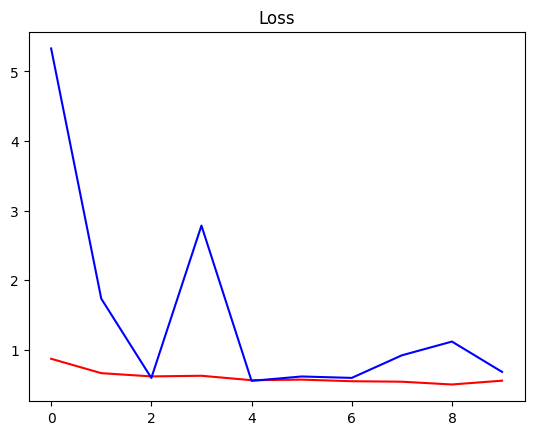

In [25]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

KeyError: 'precision_3'

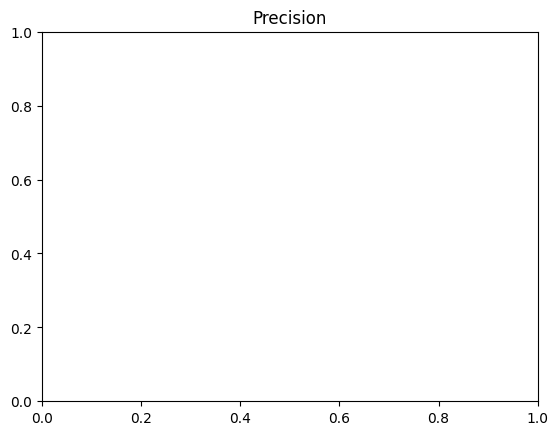

In [26]:
plt.title('Precision')
plt.plot(hist.history['precision_3'], 'r')
plt.plot(hist.history['val_precision_3'], 'b')
plt.show()

In [ ]:
plt.title('Recall')
plt.plot(hist.history['recall_3'], 'r')
plt.plot(hist.history['val_recall_3'], 'b')
plt.show()

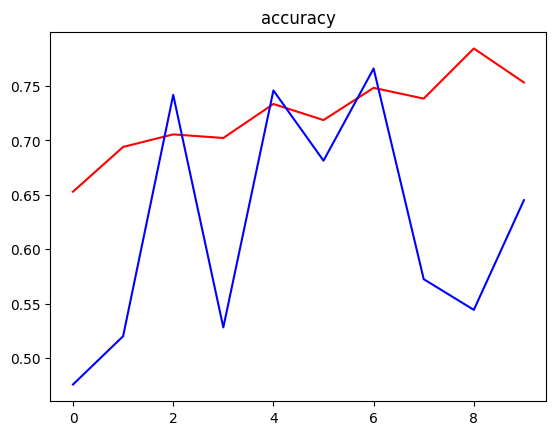

In [27]:
plt.title('accuracy')
plt.plot(hist.history['accuracy'], 'r')
plt.plot(hist.history['val_accuracy'], 'b')
plt.show()

### Bewertung des Modells

Das trainierte Modell wird mit den Testdaten bewertet, um seine Leistung zu messen.

In [ ]:
test_loss, test_accuracy, test_recall, test_precision = model.evaluate(test)

### Anzeigen der Testergebnisse
Die Ergebnisse des Modelltests, einschließlich Verlust, Genauigkeit, Recall und Precision, werden ausgegeben.

In [ ]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Recall: {test_recall}")
print(f"Test Precision: {test_precision}")

### Evaluation mit den Trainingsdaten
Das Modell wird mit den Trainingsdaten bewertet, um den Verlust und die Genauigkeit zu ermitteln. Diese Metriken geben Aufschluss darüber, wie gut das Modell auf den Daten trainiert wurde, mit denen es auch trainiert wurde.

In [ ]:
loss, accuracy = model.evaluate(train)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

### Vorbereitung der Testdaten
Das erste Batch von Testdaten wird geladen, um sowohl die Eingabedaten (X_test) als auch die zugehörigen Labels (y_test) zu erhalten.

In [ ]:
X_test, y_test = test.as_numpy_iterator().next()

### Vorhersage mit dem Modell
Das trainierte Modell wird verwendet, um Vorhersagen für die Testdaten zu treffen. Die Vorhersagen sind kontinuierliche Werte, die anschließend in binäre Werte (1 oder 0) umgewandelt werden, basierend auf einem Schwellenwert von 0,5.

In [ ]:
yhat = model.predict(X_test)

In [ ]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

### Konvertierung der Testlabels
Die Testlabels (y_test) werden in den Integer-Datentyp konvertiert, um sie mit den binären Vorhersagen vergleichen zu können.

In [ ]:
y_test.astype(int)